In [106]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import sys
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

import logging
logging.getLogger().setLevel(logging.INFO)
from dotenv import load_dotenv
load_dotenv()

sys.path.append(os.path.realpath('../'))

DROOT = '../1-data/'

cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.latest.xlsx'))
cities.head(3)

,city_name,country_id,city_id,priority
0,Amsterdam,NLD,2167,0
1,Arnhem,NLD,2226,0
2,Eindhoven,NLD,2205,0


# Aggregate all Pickles
Also make some initial data exploration. 

In [107]:
isochrones_list = []
for i, (pid, city) in enumerate(cities.iterrows()):
    
    isochrone_path = os.path.join(DROOT, '3-traveltime-cities', f'{city.city_id}.isochrones.pcl')
    if not os.path.exists(isochrone_path):
        continue;
    
    # Extract urban center and read in as pickle
    logging.info(f"Loading {city.city_name} ({city.city_id})")
    
    isochrones = gpd.GeoDataFrame(pd.read_pickle(isochrone_path))
    isochrones.insert(4, 'trmode_type', isochrones.trmode.str.replace('_off', '').str.replace('_peak', ''))
    isochrones.insert(6, 'tt_mnts_std', isochrones.tt_mnts.replace({10: 15, 25: 30}))
    
    isochrones_list.append(isochrones)

isochrones = pd.concat(isochrones_list)
isochrones = isochrones.merge(cities[['city_name', 'city_id', 'country_id']])
isochrones.sample(2)

INFO:root:Loading Amsterdam (2167)
INFO:root:Loading Arnhem (2226)
INFO:root:Loading Eindhoven (2205)
INFO:root:Loading Groningen (2269)
INFO:root:Loading Leiden (2138)
INFO:root:Loading Maastricht (2220)
INFO:root:Loading Nijmegen (2219)
INFO:root:Loading Rotterdam [The Hague] (2123)
INFO:root:Loading Tilburg (2183)
INFO:root:Loading Utrecht (2181)
INFO:root:Loading s-Hertogenbosch (2194)
INFO:root:Loading Perth (11640)
INFO:root:Loading Sydney (13043)
INFO:root:Loading Graz (3000)
INFO:root:Loading Vienna (3027)
INFO:root:Loading Brussels (2135)
INFO:root:Loading Rio de Janeiro (1361)
INFO:root:Loading Calgary (362)
INFO:root:Loading Montreal (1017)
INFO:root:Loading Toronto (875)
INFO:root:Loading Bern (2384)
INFO:root:Loading Bogota (621)
INFO:root:Loading Prague (2927)
INFO:root:Loading Hamburg (2531)
INFO:root:Loading Aarhus (2518)
INFO:root:Loading Copenhagen (2749)
INFO:root:Loading Tallinn (3255)
INFO:root:Loading Helsinki (3244)
INFO:root:Loading Paris (2046)
INFO:root:Loadin

,uid,pid,startpt,trmode,trmode_type,tt_mnts,tt_mnts_std,dep_dt,source,city_id,...,cell_pop,raster,isochrone_buf,reach_km2,reach_n,reach_km2,reach_pop,reach_geo,city_name,country_id
216279,1800-92-transit_bike_peak-30m-g,92,POINT (-1.83260 52.59544),transit_bike_peak,transit_bike,30,30,2023-08-22 08:30:00+01:00,g,1800,...,2609.771973,"POLYGON ((-1.83954 52.60031, -1.83928 52.59056...","POLYGON ((-1.94522 52.59750, -1.94556 52.59767...",9.581295e+07,209.0,2.092313e+08,282861.701504,"POLYGON ((-1.94800243939095 52.58081321907908,...",Birmingham,GBR
228840,1656-169-driving_off-10m-g,169,POINT (-6.20355 53.31916),driving_off,driving,10,15,2023-08-22 13:30:00+01:00,g,1656,...,1771.281738,"POLYGON ((-6.21088 53.32406, -6.20998 53.31425...","POLYGON ((-6.25557 53.32923, -6.25583 53.32944...",2.143035e+07,45.0,4.508827e+07,142601.562573,"POLYGON ((-6.250378452757239 53.3044413189201,...",Dublin,IRL


## Competitiveness of biking, transit, walk+transit and bike+transit compared to car traffic.

In [148]:
reach_gdf = isochrones.pivot_table(index=['city_id', 'pid'], values=['reach_pop', 'reach_geo', 'reach_km2'], columns=['tt_mnts_std', 'trmode'], aggfunc=lambda x: x)
reach_gdf = gpd.GeoDataFrame(reach_gdf)
for tt_min, trmode in reach_gdf[('reach_geo')]:
    cols = ('reach_geo', tt_min, trmode)
    reach_gdf[cols] = gpd.GeoSeries(reach_gdf[cols]).set_crs('EPSG:4326')
reach_gdf.head(2)

reach_geo  \
tt_mnts_std                                                 15   
trmode                                                 cycling   
city_id pid                                                      
362     0    POLYGON ((-114.17542 51.15612, -114.19049 51.1...   
        1    POLYGON ((-114.30722 51.14649, -114.29387 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                             driving_off   
city_id pid                                                      
362     0    POLYGON ((-114.18877 51.15612, -114.20384 51.1...   
        1    POLYGON ((-114.30722 51.14649, -114.32230 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                            driving_peak   
city_id pid                                                      
362     0    POLYGON ((-114.24218 51.15612, -114.22883 51.1...   
        1    POLYGON ((-114.29215 51.13685, -114.30722 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                        transit_bike_off   
city_id pid                                                      
362     0    POLYGON ((-114.17713 51.16576, -114.19221 51.1...   
        1    POLYGON ((-114.27709 51.12722, -114.29215 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                       transit_bike_peak   
city_id pid                                                      
362     0    POLYGON ((-114.17713 51.16576, -114.19221 51.1...   
        1    POLYGON ((-114.27709 51.12722, -114.29215 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                             transit_off   
city_id pid                                                      
362     0    POLYGON ((-114.14872 51.15612, -114.16378 51.1...   
        1    POLYGON ((-114.26545 51.13685, -114.28052 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                            transit_peak   
city_id pid                                                      
362     0    POLYGON ((-114.10696 51.14649, -114.12031 51.1...   
        1    POLYGON ((-114.26545 51.13685, -114.28052 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                                 walking   
city_id pid                                                      
362     0    POLYGON ((-114.10696 51.14649, -114.12031 51.1...   
        1    POLYGON ((-114.28052 51.14649, -114.26717 51.1...   

                                                                \
tt_mnts_std                                                 30   
trmode                                                 cycling   
city_id pid                                                      
362     0    POLYGON ((-114.24218 51.15612, -114.25726 51.1...   
        1    POLYGON ((-114.33565 51.15612, -114.35074 51.1...   

                                                                ...  \
tt_mnts_std                                                     ...   
trmode                                             driving_off  ...   
city_id pid                                                     ...   
362     0    POLYGON ((-114.44542 51.09832, -114.43208 51.0...  ...   
        1    MULTIPOLYGON (((-114.43183 51.02129, -114.4451...  ...   

                reach_pop                            

In [131]:
grid = isochrones[['pid', 'startpt', 'raster', 'city_id', 'city_name', 'country_id']].drop_duplicates()
grid

,pid,startpt,raster,city_id,city_name,country_id
0,0,POINT (4.78390 52.51746),"POLYGON ((4.77743 52.52233, 4.77676 52.51259, ...",2167,Amsterdam,NLD
16,1,POINT (4.75601 52.50772),"POLYGON ((4.74954 52.51259, 4.74888 52.50285, ...",2167,Amsterdam,NLD
32,2,POINT (4.76962 52.50772),"POLYGON ((4.76315 52.51259, 4.76248 52.50285, ...",2167,Amsterdam,NLD
48,3,POINT (4.78323 52.50772),"POLYGON ((4.77676 52.51259, 4.77609 52.50285, ...",2167,Amsterdam,NLD
64,4,POINT (4.79684 52.50772),"POLYGON ((4.79037 52.51259, 4.78970 52.50285, ...",2167,Amsterdam,NLD
...,...,...,...,...,...,...
262928,2000,POINT (-46.72391 -23.79453),"POLYGON ((-46.72825 -23.79035, -46.73011 -23.7...",1303,São Paulo,BRA
262944,2001,POINT (-46.71337 -23.79453),"POLYGON ((-46.71771 -23.79035, -46.71957 -23.7...",1303,São Paulo,BRA
262960,2002,POINT (-46.73632 -23.80290),"POLYGON ((-46.74066 -23.79871, -46.74252 -23.8...",1303,São Paulo,BRA
262976,2003,POINT (-46.72578 -23.80290),"POLYGON ((-46.73011 -23.79871, -46.73198 -23.8...",1303,São Paulo,BRA


In [178]:
query = reach_gdf['reach_pop', 30].reset_index()
query = query.merge(grid, on=['city_id', 'pid'], how='left')

# Add metrics
query = query[(query.walking > 0) & (query.cycling > 0) & (query.transit_bike_peak > 0)]
query['transit_bike_factor'] = query.transit_bike_peak / query.cycling
query['transit_walk_factor'] = query.transit_peak / query.walking
query.loc[query.transit_bike_factor > 3, 'transit_bike_factor'] = 3
query.loc[query.transit_bike_factor < 1, 'transit_bike_factor'] = 1
query.loc[query.transit_walk_factor > 6, 'transit_walk_factor'] = 6
query.loc[query.transit_walk_factor < 1, 'transit_walk_factor'] = 1
query.head(2)

,city_id,pid,cycling,driving_off,driving_peak,transit_bike_off,transit_bike_peak,transit_off,transit_peak,walking,startpt,raster,city_name,country_id,transit_bike_factor,transit_walk_factor
0,362,0,255601.714021,1.068763e+06,1.082615e+06,269514.631964,269514.631964,101317.858536,86413.173335,31232.986075,POINT (-114.13622 51.16094),"POLYGON ((-114.15043 51.16576, -114.13536 51.1...",Calgary,CAN,1.054432,2.766728
1,362,1,169846.828053,8.217765e+05,8.140310e+05,206644.519528,243343.307187,111283.488297,110464.281603,38630.414505,POINT (-114.25467 51.15131),"POLYGON ((-114.26889 51.15612, -114.25382 51.1...",Calgary,CAN,1.432722,2.859516


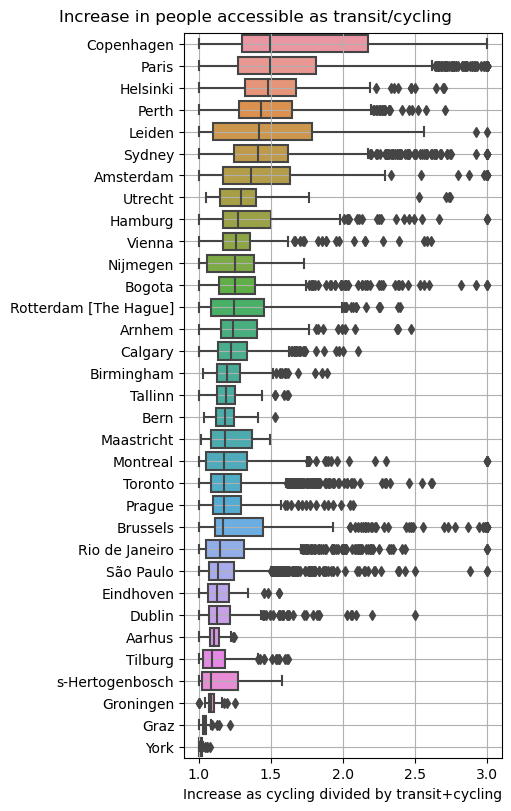

In [202]:
fig, ax = plt.subplots(figsize=(5, 8), constrained_layout=True)
fig.suptitle('Increase in people accessible as transit/cycling')
sns.boxplot(query, y='city_name', x='transit_bike_factor', ax=ax,
            order=query.groupby('city_name').transit_bike_factor.median().sort_values(ascending=False).index)
ax.set_ylabel('')
ax.set_xlabel('Increase as cycling divided by transit+cycling')
plt.grid()

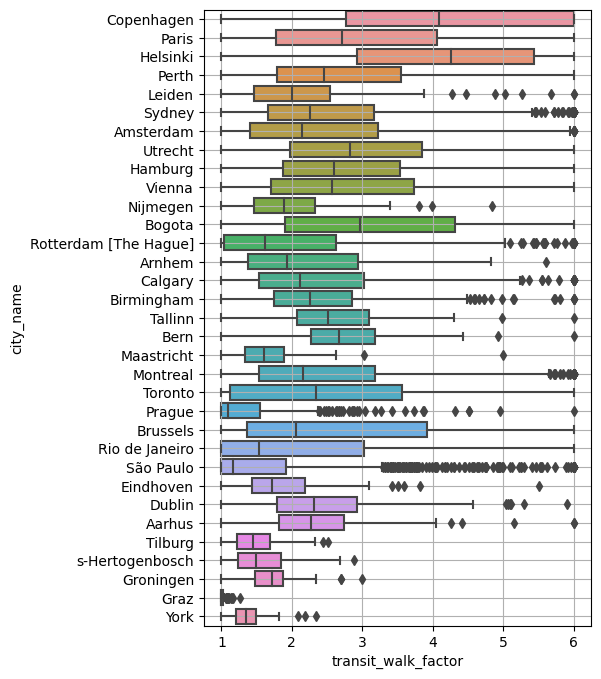

In [173]:
fig, ax = plt.subplots(figsize=(5, 8))
fig.set_title('Increase in pop_reach transit/walking')
sns.boxplot(query, y='city_name', x='transit_walk_factor', ax=ax,
            order=query.groupby('city_name').transit_bike_factor.median().sort_values(ascending=False).index)
plt.grid()

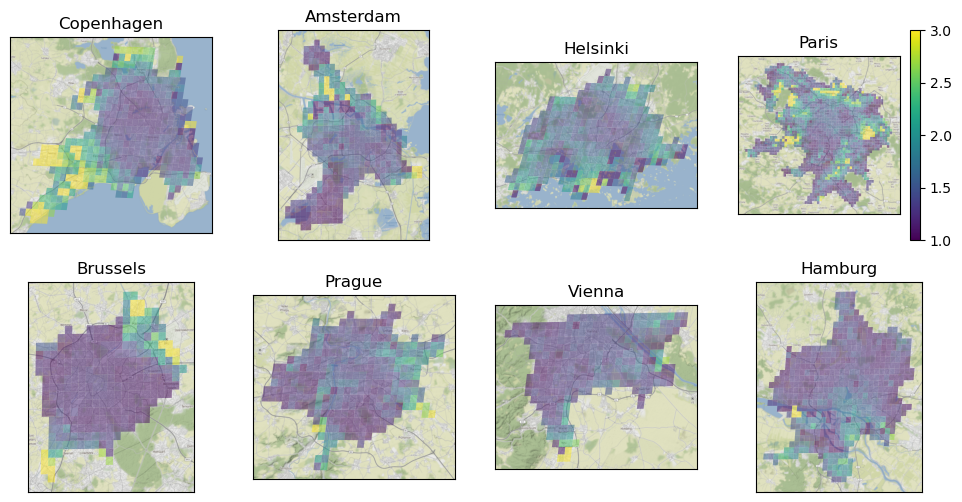

In [187]:
selection = ['Copenhagen', 'Amsterdam', 'Helsinki', 'Paris', 'Brussels', 'Prague', 'Vienna', 'Hamburg']
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6))
for i, city in enumerate(selection):
    sample = query[query.city_name == city].set_geometry('raster')
    sample = sample.to_crs(sample.estimate_utm_crs())
    ax = axs[i//4, i%4]
    ax.set_title(city)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    
    sample.plot(column='transit_bike_factor', legend=i==3, ax=ax, alpha=0.5)
    ctx.add_basemap(ax=ax, crs=sample.crs, attribution="")